# Лабораторна робота 5
## Вивчення нейронної мережі BackPropagation та EarlyStopping
##### Виконала *Ваховська Віра Миколаївна*

##### Мета:
1. Розібратись, як працює нейронна мережа BackPropagation.
2. Розібратись, як працює EarlyStopping.
3. Підключити та використовувати TensorBoard для візуалізації навчання нейронної мережі.
4. Побудувати нейронну мережу з врахуванням прошарків DropOut.
5. Порівняти різні структури нейронних мереж.

## Теоретична частина

### Нейронна мережа BackPropagation

**BackPropagation (зворотне поширення помилки)** - це метод навчання багатошарових нейронних мереж, який дозволяє оновлювати ваги мережі таким чином, щоб зменшити помилку між фактичним і бажаним виходом.

Ключові етапи роботи BackPropagation:
1. Пряме поширення: Вхідні дані проходять через нейронну мережу, генеруючи передбачення.
2. Обчислення помилки: Порівнюється передбачений результат з реальним результатом, обчислюється помилка.
3. Зворотне поширення: Помилка поширюється назад через мережу, оновлюючи ваги за допомогою градієнтного спуску.
4. Оновлення ваг: Ваги мережі коригуються з використанням обчислених градієнтів.

### EarlyStopping

**EarlyStopping** - це метод, який дозволяє припинити навчання нейронної мережі раніше, якщо її продуктивність на валідаційному наборі даних перестає покращуватись. Це допомагає запобігти перенавчанню.

### DropOut

**DropOut** - це регуляризаційна техніка, яка полягає в випадковому виключенні нейронів під час тренування моделі, що допомагає запобігти перенавчанню та
покращити узагальнюючу здатність моделі.

## Завдання

Побудуйте та навчіть кілька моделей з різними архітектурами (без DropOut, з різними кількостями прошарків, з різними кількостями нейронів в прошарках) та порівняйте їх продуктивність.

Аналіз результатів:
1. Проаналізуйте графіки втрат (loss) та точності (accuracy) на тренувальному та валідаційному наборах даних для кожної з моделей.
2. Порівняйте ефективність різних архітектур моделей.
3. Зробіть висновки щодо впливу кількості прошарків та DropOut на продуктивність моделі.

# Хід роботи

In [1]:
# Стандартні бібліотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Бібліотеки для машинного навчання та обробки даних
from sklearn.model_selection import train_test_split

# TensorFlow та Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.callbacks import TensorBoard

# Keras Tuner
import keras
import keras_tuner as kt

### 1. Вибір навчального набору даних

In [2]:
# Завантаження даних
train = pd.read_csv("titanic/train.csv")
test = pd.read_csv("titanic/test.csv")
IDtest = test["PassengerId"]

In [3]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [4]:
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


#### Про датасет

| Змінна     | Визначення                                 | Ключ                                                                                  |
|------------|--------------------------------------------|---------------------------------------------------------------------------------------|
| survival   | Статус виживання пасажира                 | 0 = Ні, 1 = Так                                                                       |
| pclass     | Клас квитка, показник соціально-економічного статусу (SES) | 1 = 1-й (Вищий), 2 = 2-й (Середній), 3 = 3-й (Нижчий)                                 |
| sex        | Стать пасажира                            | Н/Д                                                                                   |
| age        | Вік пасажира у роках                      | Дробовий, якщо менше 1 року. Оцінений вік подається у вигляді xx.5                    |
| sibsp      | Кількість братів/сестер або подружжя на борту | Брат/сестра = брат, сестра, зведені брат чи сестра; Подружжя = чоловік, дружина (коханки та наречені не враховані) |
| parch      | Кількість батьків/дітей на борту          | Батьки = мати, батько; Діти = син, дочка, зведені син чи дочка (діти з нянею отримали `parch = 0`) |
| ticket     | Номер квитка                              | Н/Д                                                                                   |
| fare       | Вартість квитка                           | Н/Д                                                                                   |
| cabin      | Номер каюти                               | Н/Д                                                                                   |
| embarked   | Порт посадки                              | C = Шербур, Q = Квінстаун, S = Саутгемптон                                           |

##### Примітки

- **pclass**: вказує соціально-економічний статус:
  - 1 = вищий клас;
  - 2 = середній клас;
  - 3 = нижчий клас.

- **age**: представляє вік пасажира. Якщо вік менше 1 року, він вказується як дробовий. Оцінені віки подаються у вигляді `xx.5`.

- **sibsp**:
  - брат/сестра = брат, сестра, зведені брат чи сестра;
  - подружжя = чоловік, дружина (коханки та наречені не враховані).

- **parch**:
  - батьки = мати, батько;
  - діти = син, дочка, зведені син чи дочка;
  - діти, які подорожували лише з нянею, отримали значення `parch = 0`.


### 2. Попередня обробка даних

In [5]:
# Об'єднання train і test для однакової кількості ознак
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [6]:
dataset.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
# Заповнення порожніх значень NaN
dataset = dataset.fillna(np.nan)

# Перевірка пропущених значень
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Детальний огляд усіх ознак

In [11]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

##### Sex

In [12]:
# 0 - чоловік, 1 - жінка
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

##### Name

In [13]:
# Виділення Title з Name
dataset["Title"] = dataset["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)
print("Унікальні заголовки:")
print(dataset["Title"].value_counts())

Унікальні заголовки:
Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Mme               1
Don               1
Sir               1
Lady              1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64


In [14]:
# Групування рідкісних префіксів в єдину категорію
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'the Countess']
dataset["Title"] = dataset["Title"].replace(rare_titles, 'Rare')
print("Заголовки після групування:")
print(dataset["Title"].value_counts())

Заголовки після групування:
Title
Mr        757
Miss      260
Mrs       197
Master     61
Rare       29
Ms          2
Mlle        2
Mme         1
Name: count, dtype: int64


In [15]:
# Зіставлення заголоків та цілих цисел
title_mapping = {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
dataset["Title"] = dataset["Title"].map(title_mapping)
print("Зіставлені заголовки:")
print(dataset["Title"].value_counts())

Зіставлені заголовки:
Title
2    757
1    462
0     61
3     29
Name: count, dtype: int64


In [16]:
# Показати кількість кожного титулу у вигляді таблиці
title_counts = dataset["Title"].value_counts().reset_index()
title_counts.columns = ["Title", "Count"]
print(title_counts)

   Title  Count
0      2    757
1      1    462
2      0     61
3      3     29


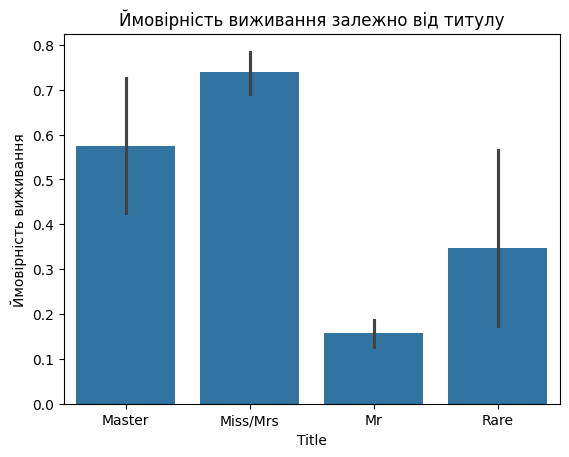

In [17]:
# Візуалізувати ймовірність виживання залежно від титулу
sns.barplot(x=dataset["Title"], y=dataset["Survived"])
plt.xticks([0, 1, 2, 3], ["Master", "Miss/Mrs", "Mr", "Rare"])
plt.ylabel("Ймовірність виживання")
plt.title("Ймовірність виживання залежно від титулу")
plt.show()

In [18]:
# Видалення та конвертування
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

##### Fare

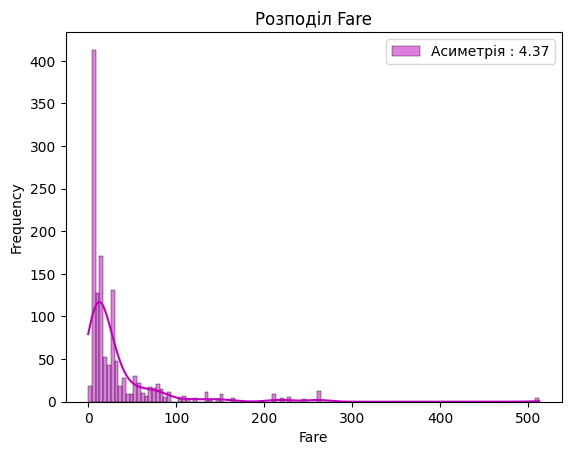

In [19]:
# Візуалізація розподілу Fare
g = sns.histplot(
    dataset["Fare"], 
    color="m", 
    kde=True,
    label="Асиметрія : %.2f" % (dataset["Fare"].skew())
)
plt.legend(loc="best")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.title("Розподіл Fare")
plt.show()

Розподіл Fare нерівномірний, тобто є сильний перекіс. Через це модель може надавати занадто велику вагу великим значенням, навіть після масштабування.  Я вирішила використати Log, щоб згладити розподіл.

In [20]:
# Логарифмічне перетворення Fare
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

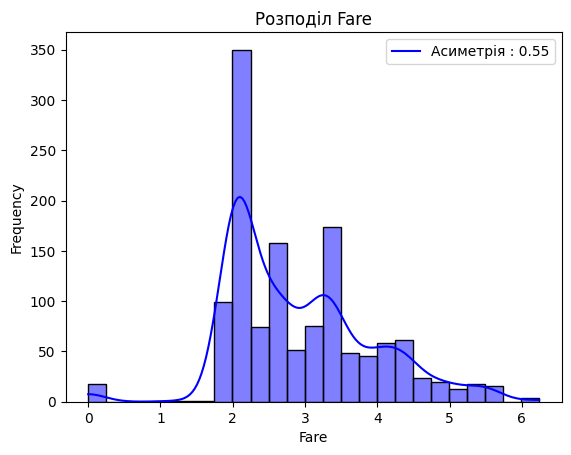

In [21]:
# Візуалізація розподілу Fare
g = sns.histplot(
    dataset["Fare"], 
    color="b", 
    kde=True,
)
plt.legend(["Асиметрія : %.2f" % (dataset["Fare"].skew())], loc="best")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.title("Розподіл Fare")
plt.show()

##### Age

Колонка Age містить багато пропущених значень. Оскільки вік може впливати на шанс виживання, краще зберегти цей показник і заповнити відсутні дані. Для вирішення проблеми я проаналізувала найбільш корельовані з віком ознаки.

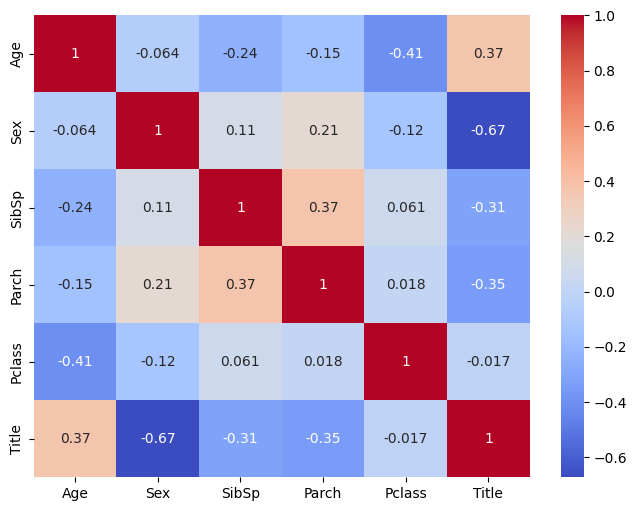

In [22]:
correlation_matrix = dataset[["Age", "Sex", "SibSp", "Parch", "Pclass", "Title"]].corr()
plt.figure(figsize=(8, 6))
g = sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True)
plt.show()

In [23]:
# Групування за Title і Pclass для розрахунку медіанного віку
median_ages = dataset.groupby(['Title', 'Pclass'])['Age'].median()

# Заповнення пропущених значень у колонці Age на основі медіан Title і Pclass
for i in dataset.index:
    if pd.isnull(dataset.loc[i, 'Age']):  # Перевірка, чи значення відсутнє
        title = dataset.loc[i, 'Title']
        pclass = dataset.loc[i, 'Pclass']
        
        # Якщо комбінація Title і Pclass існує, заповнити відповідним медіанним значенням
        if (title, pclass) in median_ages:
            dataset.loc[i, 'Age'] = median_ages[(title, pclass)]
        else:
            dataset.loc[i, 'Age'] = dataset['Age'].median()  # Якщо немає відповідності, використовувати загальну медіану

# Перевірка, чи залишилися пропущені значення у колонці Age
missing_age_count_after = dataset["Age"].isnull().sum()
print(f"Кількість пропущених значень Age після заповнення: {missing_age_count_after}")

Кількість пропущених значень Age після заповнення: 0


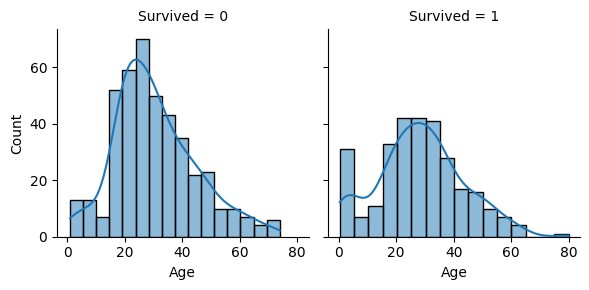

In [24]:
# Візуалізація розподілу віку з розбивкою за колонкою Survived
g = sns.FacetGrid(train, col='Survived')
g.map_dataframe(sns.histplot, x="Age", kde=True)
g.set_axis_labels("Age", "Count")
plt.show()

##### Embarked

Оскільки лише два відсутні значення, я вирішила заповнити їх найбільш частим значенням.

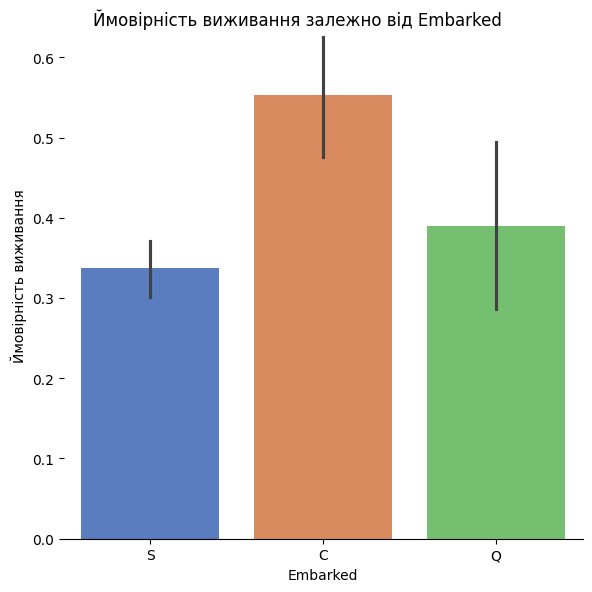

In [25]:
# Дослідження залежності між Embarked і Survived
g = sns.catplot(
    x="Embarked",
    y="Survived",
    hue="Embarked",
    data=train,
    kind="bar",
    height=6,
    palette="muted",
    legend=False
)

g.despine(left=True)
g.set_ylabels("Ймовірність виживання")
g.fig.suptitle("Ймовірність виживання залежно від Embarked")
plt.show()

In [26]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

In [27]:
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

##### Cabin

In [28]:
# Замінюємо відсутні значення в колонці 'Cabin' на 'X' та залишаємо лише тип каюти
dataset['Cabin'] = dataset['Cabin'].fillna('X')
dataset['Cabin'] = dataset['Cabin'].str[0]

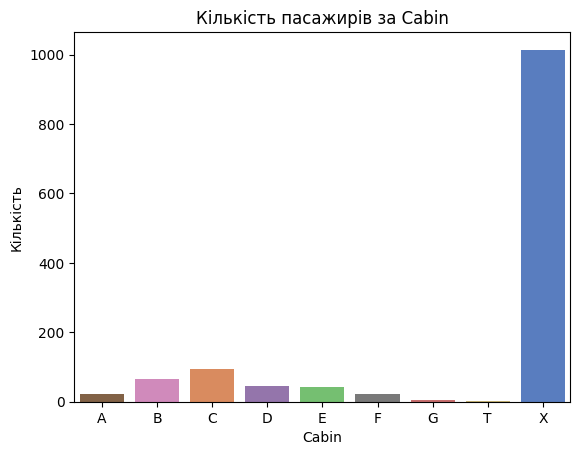

In [29]:
sns.countplot(
    data=dataset,
    x="Cabin",
    hue="Cabin",
    order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'],
    palette="muted"
)
plt.title("Кількість пасажирів за Cabin")
plt.ylabel("Кількість")
plt.xlabel("Cabin")
plt.show()

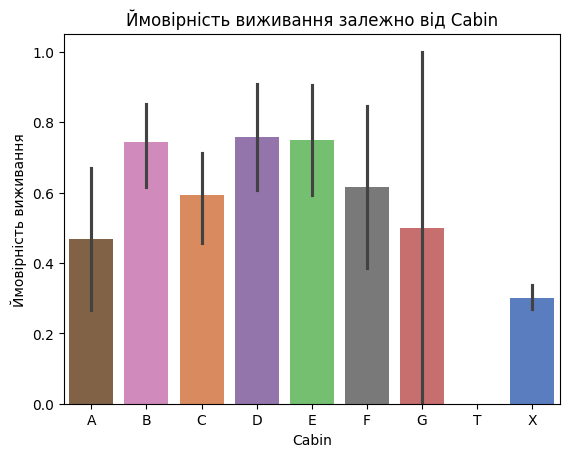

In [30]:
g = sns.barplot(
    x="Cabin",
    y="Survived",
    hue="Cabin",
    data=dataset,
    order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'],
    palette="muted"
)

g.set_title("Ймовірність виживання залежно від Cabin")
g.set_ylabel("Ймовірність виживання")
g.set_xlabel("Cabin")
plt.show()

Пасажири з каютами мали більше шансів на виживання, ніж ті, хто не мав (X).

In [31]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"], prefix="Cabin")

##### Ticket

In [32]:
# Виділення префікса квитка
Ticket = []
for i in list(dataset["Ticket"]):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0])  # Префікс
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [33]:
dataset = pd.get_dummies(dataset, columns=["Ticket"], prefix="T")

##### Pclass

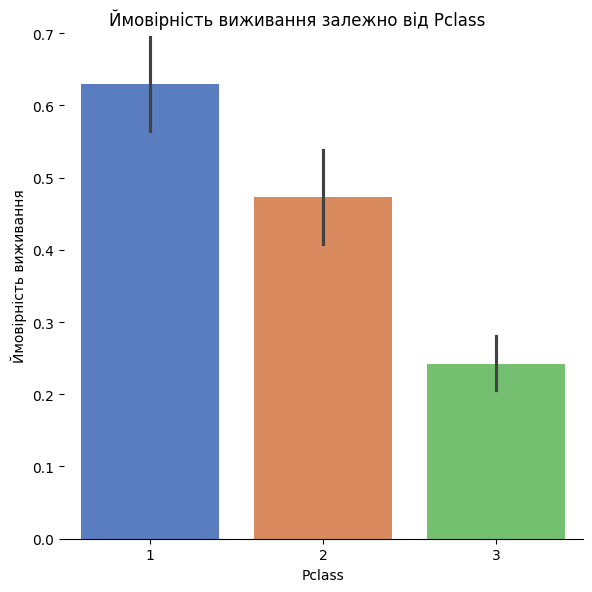

In [34]:
# Дослідження залежності між Pclass і Survived
g = sns.catplot(
    x="Pclass",
    y="Survived",
    hue="Pclass",
    data=train,
    kind="bar",
    height=6,
    palette="muted",
    legend=False
)

g.despine(left=True)
g.set_ylabels("Ймовірність виживання")
g.fig.suptitle("Ймовірність виживання залежно від Pclass")
plt.show()

In [35]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"], prefix="Pc")

##### SibSp

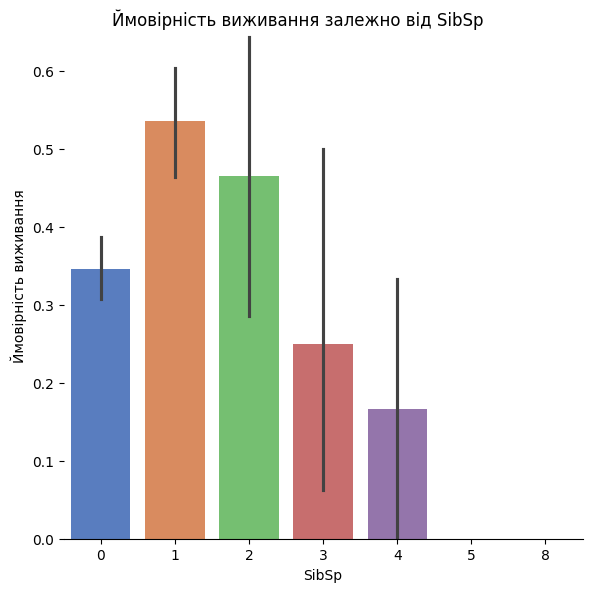

In [36]:
# Дослідження залежності між SibSp і Survived
g = sns.catplot(
    x="SibSp", 
    y="Survived", 
    hue="SibSp",  
    data=train, 
    kind="bar", 
    height=6, 
    palette="muted", 
    legend=False  
)

g.despine(left=True)
g.set_ylabels("Ймовірність виживання")
g.fig.suptitle("Ймовірність виживання залежно від SibSp")
plt.show()

##### Parch

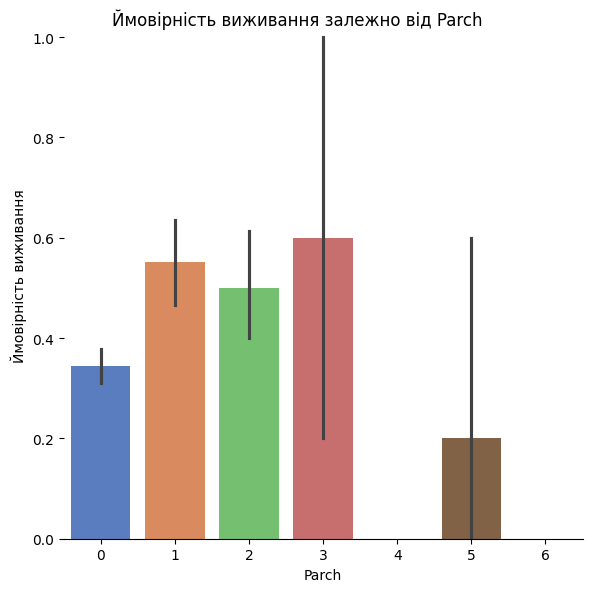

In [37]:
# Дослідження залежності між Parch і Survived
g = sns.catplot(
    x="Parch",
    y="Survived",
    hue="Parch",
    data=train,
    kind="bar",
    height=6,
    palette="muted",
    legend=False
)

g.despine(left=True)
g.set_ylabels("Ймовірність виживання")
g.fig.suptitle("Ймовірність виживання залежно від Parch")
plt.show()

##### PassengerId

In [38]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [39]:
dataset = pd.get_dummies(dataset, columns = ["Title"])

In [40]:
dataset = dataset.astype({col: int for col in dataset.select_dtypes('bool').columns})

In [41]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S,Cabin_A,...,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3,Title_0,Title_1,Title_2,Title_3
0,0.0,0,22.0,1,0,1.981001,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,1.0,1,38.0,1,0,4.266662,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
3,1.0,1,35.0,1,0,3.972177,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0
4,0.0,0,35.0,0,0,2.085672,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0


In [42]:
# Розділяємо дані на тренувальні та тестові набори
train = dataset.iloc[:train_len].copy()  # Копія для тренувального набору
test = dataset.iloc[train_len:].copy()  # Копія для тестового набору

# Видаляємо колонку "Survived" із тестового набору (її немає у реальних тестових даних)
test = test.drop(labels=["Survived"], axis=1)

# Конвертуємо колонку "Survived" (int) у тренувальному наборі
train.loc[:, "Survived"] = train["Survived"].astype(int)

# Відокремлюємо ознаки та цільову змінну
Y_train = train["Survived"]  # Цільова змінна
X_train = train.drop(labels=["Survived"], axis=1)  # Ознаки

In [43]:
# Поділ на тренувальну і тестову вибірки
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

### Тестування прикладу з лабораторної

#### 1. Налаштування нейронної мережі

In [44]:
example_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Компіляція моделі
example_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### 2. Налаштування EarlyStopping та TensorBoard

In [45]:
# Директорія для зберігання логів TensorBoard
log_dir = os.path.join("logs", "fit", "Example Model")

# Налаштування колбеків
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Навчання моделі з використанням колбеків
history = example_model.fit(
    X_train, Y_train,
    epochs=50,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping, tensorboard]
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4932 - loss: 1.5833 - val_accuracy: 0.6034 - val_loss: 0.7229
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5751 - loss: 1.0928 - val_accuracy: 0.6369 - val_loss: 0.6326
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5674 - loss: 0.9693 - val_accuracy: 0.7207 - val_loss: 0.6504
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5983 - loss: 0.7506 - val_accuracy: 0.7374 - val_loss: 0.6593
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6111 - loss: 0.7488 - val_accuracy: 0.7654 - val_loss: 0.6719
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6248 - loss: 0.6873 - val_accuracy: 0.6816 - val_loss: 0.6807
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6523 - loss: 0.6569 - val_accuracy: 0.7598 - val_loss: 0.6711


#### 3. Запуск TensorBoard

In [70]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit --host localhost --port=6006 

1. Відкрити anaconda prompt
2. Переміститись у папку з лабораторною - cd C:\Users\Michael\Documents\CHI\labs\lab5 
3. Активувати середовище - activate tf-gpu
4. Вставити команду - tensorboard --logdir logs/fit --host localhost --port 6006 
5. Перейти - http://localhost:6006/

### Завдання

In [47]:
# Модель без DropOut
model_no_dropout = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Модель з більшою кількістю прошарків
model_more_layers = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Модель з DropOut
model_with_dropout = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [48]:
# Компіляція моделей
models = {
    "No DropOut": model_no_dropout,
    "More Layers": model_more_layers,
    "With DropOut": model_with_dropout
}

for name, model in models.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
# Головна директорія для логів
base_log_dir = "logs/fit"

# Налаштування колбеків
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Навчання моделей та збереження історії
histories = {}
for name, model in models.items():
    print(f"Навчання моделі: {name}")
    
    # Директорія для конкретної моделі
    model_log_dir = os.path.join(base_log_dir, name)
    tensorboard = TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    
    # Навчання
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=50,
        callbacks=[early_stopping, tensorboard],
        verbose=1
    )
    histories[name] = history

Навчання моделі: No DropOut
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5774 - loss: 0.7056 - val_accuracy: 0.6536 - val_loss: 0.6099
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7202 - loss: 0.5864 - val_accuracy: 0.7821 - val_loss: 0.5348
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7746 - loss: 0.4957 - val_accuracy: 0.8045 - val_loss: 0.4777
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8281 - loss: 0.4417 - val_accuracy: 0.8101 - val_loss: 0.4529
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8077 - loss: 0.4413 - val_accuracy: 0.7374 - val_loss: 0.5657
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7995 - loss: 0.4825 - val_accuracy: 0.8268 - val_loss: 0.4364
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8211 - loss: 0.4206 - val_accuracy: 0.8156 - val_loss: 0.4424
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8338 - loss: 0.3960 - val

In [50]:
print(histories[next(iter(histories))].history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [51]:
# Ініціалізуємо список для результатів
results = []

# Обробляємо результати кожної моделі
for name, history in histories.items():
    last_epoch = len(history.history['val_loss']) - 1
    results.append([
        name,
        last_epoch + 1,  # Додаємо 1, бо індексація починається з 0
        history.history['accuracy'][last_epoch],
        history.history['val_accuracy'][last_epoch],
        history.history['loss'][last_epoch],
        history.history['val_loss'][last_epoch],
    ])

# Створюємо DataFrame
results_df = pd.DataFrame(results, columns=[
    "Model Name", "Last Epoch", "Train Accuracy", "Validation Accuracy", "Train Loss", "Validation Loss"
])

# Виводимо таблицю без індексу
print(results_df.to_string(index=False))

  Model Name  Last Epoch  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
  No DropOut          15        0.830056             0.815642    0.387499         0.427732
 More Layers          12        0.851124             0.798883    0.378397         0.453499
With DropOut          50        0.842697             0.826816    0.396266         0.438998


In [52]:
def plot_history(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', color='blue')
    axes[0].plot(history.history['val_accuracy'], label='Validation', color='orange')
    axes[0].set_title(f'{title} - Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train', color='blue')
    axes[1].plot(history.history['val_loss'], label='Validation', color='orange')
    axes[1].set_title(f'{title} - Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

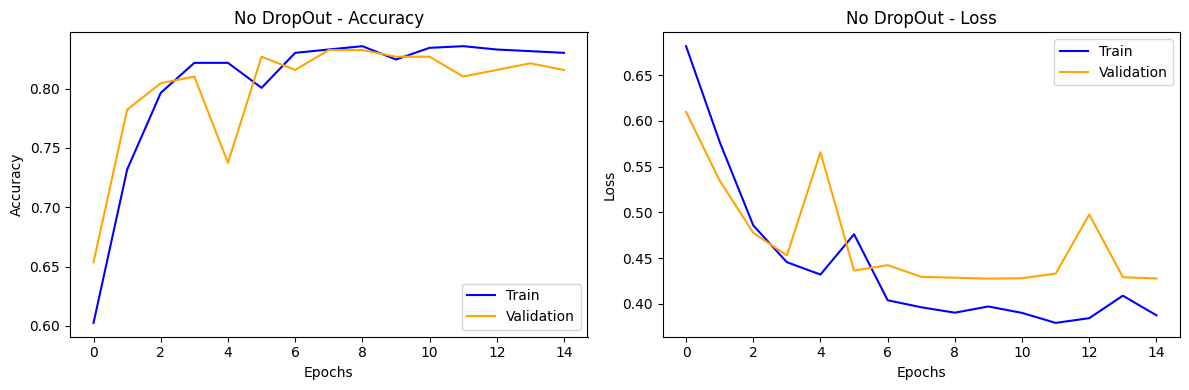

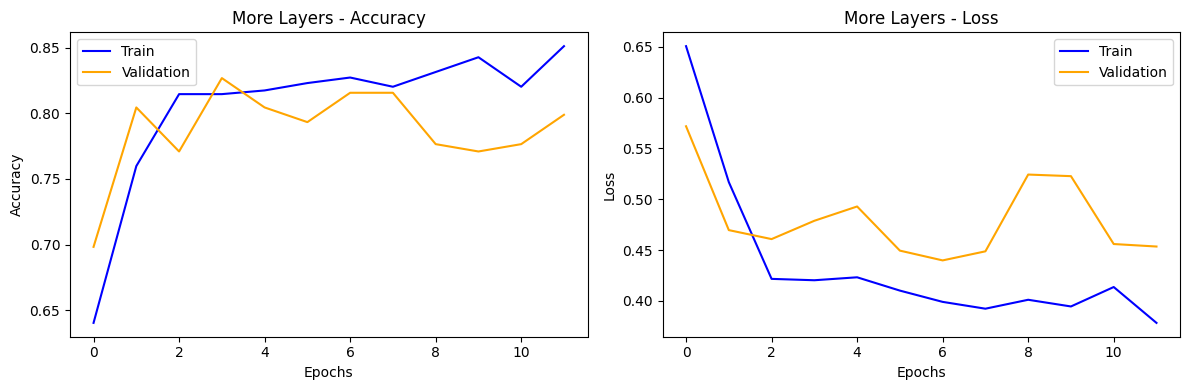

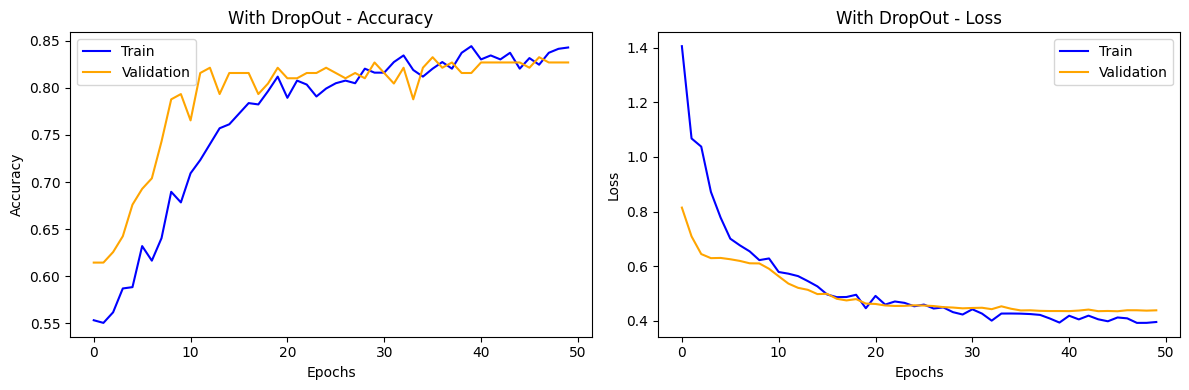

In [53]:
# Побудова графіків для кількох моделей
for name, history in histories.items():
    plot_history(history, title=name)

In [71]:
# %reload_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/fit --host localhost --port=6006 

Reusing TensorBoard on port 6006 (pid 13856), started 0:02:09 ago. (Use '!kill 13856' to kill it.)

Виконати дві команди в cmd (windows 10):
- taskkill /im tensorboard.exe /f
- del /q %TMP%\.tensorboard-info\*

### Додатково (KerasTuner)

In [55]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh', 'elu']),
        ))
        if hp.Boolean(f'dropout_{i}'):
            model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [56]:
# Налаштування tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband_logs',
    project_name='model_tuning'
)

# Запуск пошуку
tuner.search(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping],
    verbose=1
)

Trial 90 Complete [00h 00m 15s]
val_accuracy: 0.8212290406227112

Best val_accuracy So Far: 0.8379888534545898
Total elapsed time: 00h 05m 36s


In [57]:
# Отримання найкращих гіперпараметрів
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'num_layers': 1,
 'units_0': 160,
 'activation_0': 'tanh',
 'dropout_0': True,
 'lr': 0.002555813499071932,
 'dropout_rate_0': 0.1,
 'units_1': 32,
 'activation_1': 'relu',
 'dropout_1': False,
 'dropout_rate_1': 0.1,
 'units_2': 32,
 'activation_2': 'elu',
 'dropout_2': True,
 'dropout_rate_2': 0.5,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0061'}

In [58]:
hyperband_log_dir = os.path.join(base_log_dir, "Hyperband Model")
tensorboard_hyperband = TensorBoard(log_dir=hyperband_log_dir, histogram_freq=1)

# Побудова та навчання моделі з найкращими параметрами
model_hyperband = tuner.hypermodel.build(best_hps)
history = model_hyperband.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    callbacks=[early_stopping, tensorboard_hyperband],
    verbose=1
)

# Збереження історії для аналізу
histories["Hyperband Model"] = history

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5859 - loss: 0.6907 - val_accuracy: 0.7430 - val_loss: 0.5530
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7527 - loss: 0.5078 - val_accuracy: 0.8045 - val_loss: 0.4695
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8499 - loss: 0.3925 - val_accuracy: 0.8101 - val_loss: 0.4597
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8204 - loss: 0.4289 - val_accuracy: 0.8045 - val_loss: 0.4464
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8270 - loss: 0.4174 - val_accuracy: 0.7709 - val_loss: 0.4841
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8250 - loss: 0.4101 - val_accuracy: 0.8101 - val_loss: 0.4679
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8319 - loss: 0.4297 - val_accuracy: 0.8101 - val_loss: 0.4565
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8204 - loss: 0.3945 - val_accuracy: 0.8156 - val_loss

In [59]:
histories

{'No DropOut': <keras.src.callbacks.history.History at 0x2966bebfb80>,
 'More Layers': <keras.src.callbacks.history.History at 0x2966bebf0a0>,
 'With DropOut': <keras.src.callbacks.history.History at 0x2966bec9fd0>,
 'Hyperband Model': <keras.src.callbacks.history.History at 0x29620e3f1f0>}

In [60]:
# Оновлення таблиці результатів
results.append([
    "Hyperband Model",
    len(history.history['val_loss']),
    history.history['accuracy'][-1],
    history.history['val_accuracy'][-1],
    history.history['loss'][-1],
    history.history['val_loss'][-1],
])

results_df = pd.DataFrame(results, columns=[
    "Model Name", "Last Epoch", "Train Accuracy", "Validation Accuracy", "Train Loss", "Validation Loss"
])

print(results_df.to_string(index=False))

     Model Name  Last Epoch  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
     No DropOut          15        0.830056             0.815642    0.387499         0.427732
    More Layers          12        0.851124             0.798883    0.378397         0.453499
   With DropOut          50        0.842697             0.826816    0.396266         0.438998
Hyperband Model          14        0.824438             0.832402    0.402455         0.452268


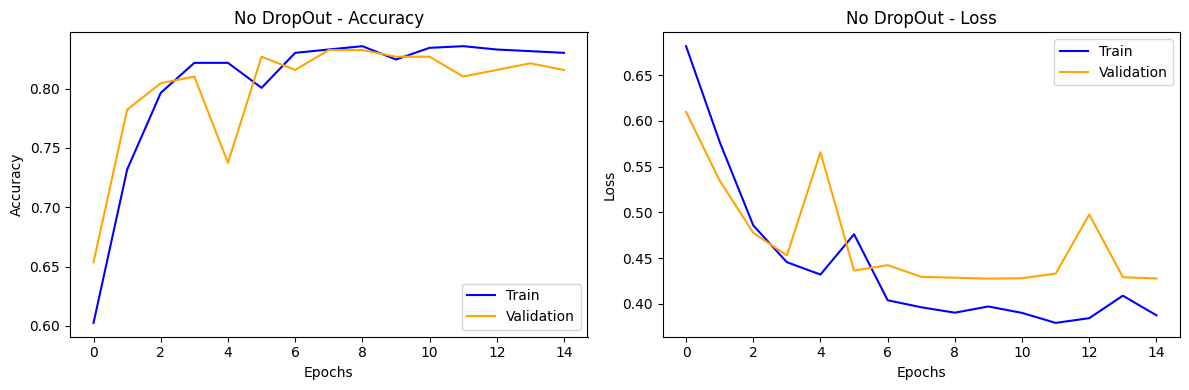

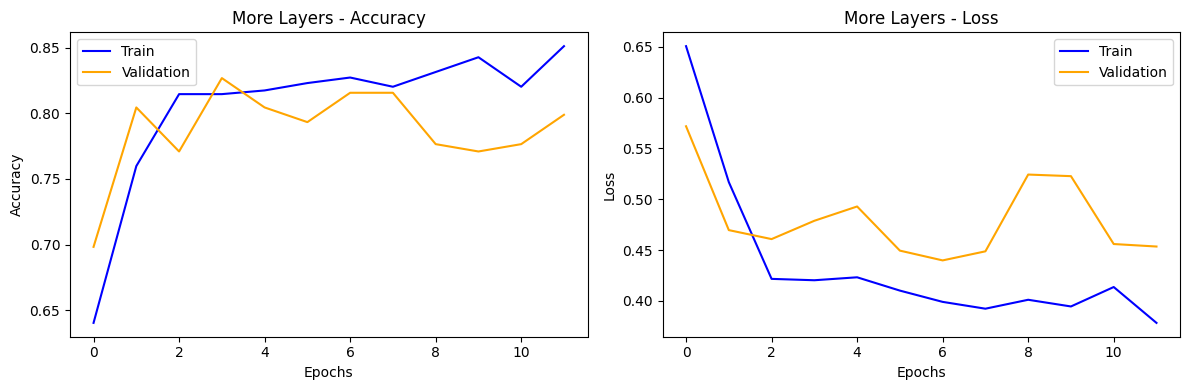

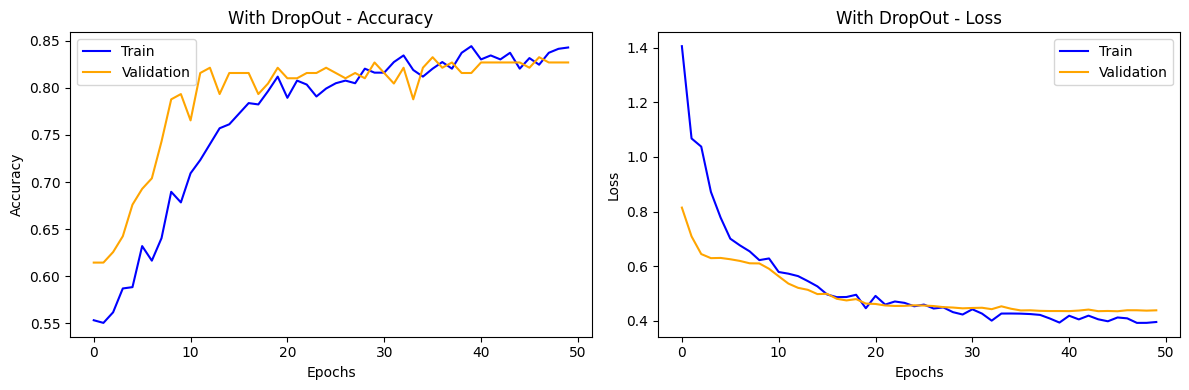

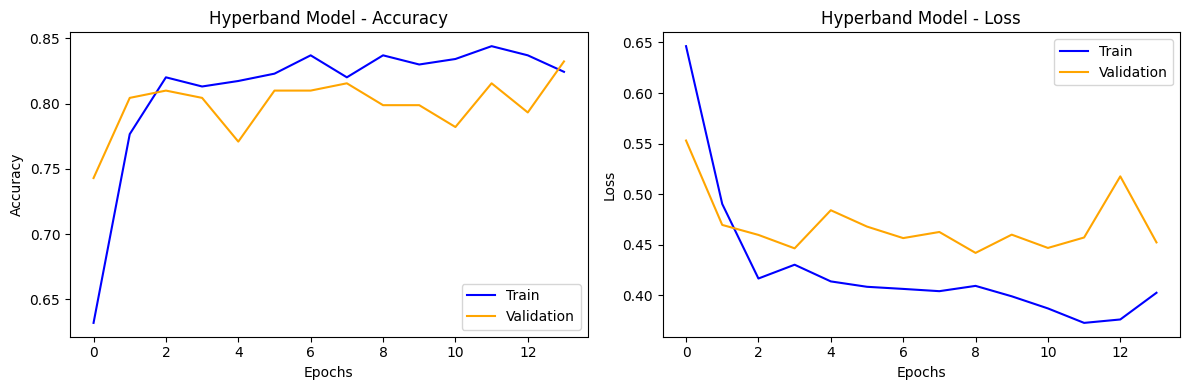

In [61]:
# Побудова графіків
for name, history in histories.items():
    plot_history(history, name)

### Завантаження файлу результату

In [62]:
# Передбачення на тестових даних
test_predictions = (model_hyperband.predict(test) > 0.5).astype(int).flatten()  # Переведення в 0 або 1

# Форматування результатів
test_Survived = pd.Series(test_predictions, name="Survived")
results = pd.concat([IDtest, test_Survived], axis=1)

# Збереження у файл CSV
results.to_csv("submission.csv", index=False)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


### Висновки

У ході виконання лабораторної роботи було використано вже раніше підготовлений датасет Titanic, що містить дані про пасажирів та їх виживання під час аварії корабля. Метою роботи було побудова кількох моделей нейронних мереж для розв'язання задачі бінарної класифікації (визначення, чи вижив пасажир), проведення аналізу їхніх результатів і порівняння ефективності.

Було успішно створено, натреновано та оцінено три моделі нейронних мереж з різними архітектурами для вирішення задачі бінарної класифікації. Отримані результати свідчать, що включення DropOut до архітектури значно знижує ймовірність перенавчання та покращує загальну узагальнювальну здатність моделі. Також було встановлено, що збільшення кількості шарів і нейронів не завжди гарантує покращення продуктивності, а натомість може сприяти перенавчанню.

Використання TensorBoard дало змогу детально візуалізувати процес навчання, спостерігати за зміною втрат і точності на тренувальних і валідаційних наборах, що дозволило вчасно застосовувати EarlyStopping для запобігання зайвого тренування. Крім того, використання Keras Tuner допомогло автоматизувати пошук оптимальних гіперпараметрів, забезпечуючи баланс між складністю моделі та її продуктивністю.

Загалом, робота продемонструвала важливість оптимізації структури нейронної мережі та застосування методів регуляризації для покращення якості моделей, а також показала практичну значущість інструментів моніторингу та автоматичного налаштування гіперпараметрів. Але варто також взяти до уваги, що кожен раз при запуску (навіть з однаковими даними), були різні результати, через те, що нейронна мережа активізується рандомними вагами.